<a href="https://colab.research.google.com/github/rohan260696/CE888-LAB-Solutions-/blob/master/CE888%20PROJECT/%20CE888_PRJ_DATA_GEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### Modified the below code to generate data in the form of 8 board positions, current player and the next move selected using MCTS to be played




In [0]:
# This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
# The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
# It aims to have the clearest and simplest possible code, and for the sake of clarity, the code
# is orders of magnitude less efficient than it could be made, particularly by using a 
# state.GetRandomMove() or state.DoRandomRollout() function.
# 
# Example GameState classes for Nim, OXO and Othello are included to give some idea of how you
# can write your own GameState use UCT in your 2-player game. Change the game to be played in 
# the UCTPlayGame() function at the bottom of the code.
# 
# Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
# 
# Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment
# remains in any distributed code.
# 
# For more information about Monte Carlo Tree Search check out our web site at www.mcts.ai

from math import *
import random

class GameState:
    """ A state of the game, i.e. the game board. These are the only functions which are
        absolutely necessary to implement UCT in any 2-player complete information deterministic 
        zero-sum game, although they can be enhanced and made quicker, for example by using a 
        GetRandomMove() function to generate a random move during rollout.
        By convention the players are numbered 1 and 2.
    """
    def __init__(self):
            self.playerJustMoved = 2 # At the root pretend the player just moved is player 2 - player 1 has the first move
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = GameState()
        st.playerJustMoved = self.playerJustMoved
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerJustMoved.
        """
        self.playerJustMoved = 3 - self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """

    def __repr__(self):
        """ Don't need this - but good style.
        """
        pass


class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is p2 - p1 has the first move
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == playerjm:
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []: return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self):
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]]
            if i % 3 == 2: s += "\n"
        return s


class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self):
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s


def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree

        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while state.GetMoves() != []: # while state is non-terminal
            state.DoMove(random.choice(state.GetMoves()))

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - can be omitted
    # if verbose: print(rootnode.TreeToString(0))
    # else: print(rootnode.ChildrenToString())

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited
                
def UCTPlayGame():
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    state = OXOState() # uncomment to play OXO
    while state.GetMoves() != []:
        
        x = str(state.board) ## captures the current state of the board 

        data['State0'].append (x[1]) ## the following code breaks the data state (string) for board postions 0 to 8 
        data['State1'].append (x[4]) ## and stores it in the data dicitonary for generating dataset
        data['State2'].append (x[7])
        data['State3'].append (x[10])
        data['State4'].append (x[13])
        data['State5'].append (x[16])
        data['State6'].append (x[19])
        data['State7'].append (x[22])
        data['State8'].append (x[25])

        #print(str(state))
        if state.playerJustMoved == 1:
            m = UCT(rootstate=state, itermax=1000, verbose=False)  # play with values for itermax and verbose = True
        else:
            m = UCT(rootstate=state, itermax=100, verbose=False)
        #print("Best Move: " + str(m) + "\n")
        state.DoMove(m)
        
        data['Move'].append(m) # store the next move 
        data['Player'].append(state.playerJustMoved) # store the current player 

        if state.GetResult(state.playerJustMoved) != False:
            # print(str(state))
            break
    # if state.GetResult(state.playerJustMoved) == 1.0:
    #     print("Player " + str(state.playerJustMoved) + " wins!")
    # elif state.GetResult(state.playerJustMoved) == 0.0:
    #     print("Player " + str(3 - state.playerJustMoved) + " wins!")
    # else: print("Nobody wins!")

# if __name__ == "__main__":
#     """ Play a single game to the end using UCT for both players. 
#     """
#     UCTPlayGame()

            

In [0]:
import pandas as pd

# this is the dataset framework
data = {
        'State0':[],
        'State1':[],
        'State2':[],
        'State3':[],
        'State4':[],
        'State5':[],
        'State6':[],
        'State7':[],
        'State8':[],
        'Player':[],
        'Move'  :[]
       }

# play the game of tic-tac-toe 500 times and create data.
for i in range(0,500):
  UCTPlayGame()



In [0]:
# use the data generated in the prev step to generate a pandas dataframe
dataframe = pd.DataFrame(data, columns= ('State0','State1','State2','State3','State4','State5','State6','State7','State8','Player','Move'))
dataframe.head(10)

,State0,State1,State2,State3,State4,State5,State6,State7,State8,Player,Move
0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,2,3
2,1,0,0,2,0,0,0,0,0,1,4
3,1,0,0,2,1,0,0,0,0,2,8
4,1,0,0,2,1,0,0,0,2,1,2
5,1,0,1,2,1,0,0,0,2,2,6
6,1,0,1,2,1,0,2,0,2,1,1
7,0,0,0,0,0,0,0,0,0,1,4
8,0,0,0,0,1,0,0,0,0,2,0
9,2,0,0,0,1,0,0,0,0,1,2


In [0]:
# export the dataset as a csv file.
export = dataframe.to_csv(r'CE888PROJECT_DATASET.csv',index = False)

In [0]:
dataframe['Move'].value_counts()

4    500
0    500
3    484
6    480
1    480
8    480
7    478
2    478
5    478
Name: Move, dtype: int64

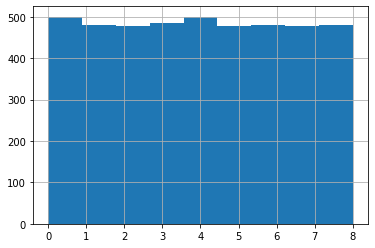

In [0]:
dataframe.Move.hist(bins = 9)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y,x = pd.DataFrame(dataframe['Move']),dataframe.drop(columns= 'Move')
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.33, random_state = 42)